<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter06/ch6_nb4_preparing_data_for_smart_car_apps.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 6: Enhancing and Segmenting Images </strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 4:</small><br/>Preparing Data for Smart Car Applications</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In Chapter 6, <em><strong>semantic segmentation</em></strong> for autonomous driving is a recurring example. Indeed, the rise of self-driving cars is probably one of the most exciting products of computer vision and deep learning nowadays. With more advanced tools for semantic segmentation, on-board computers are able to better understand their environment (e.g., pedestrians crossing in front of the car) in order to act accordingly (e.g., to brake).
<br/><br/>
In the two following notebooks, we will illustrate how the skills we have been honing so far can be applied to such a complex use-case. We will implement some pipelines for object/instance segmentation, and train them for pictures shot by an on-board camera. We will use a famous dataset: <em><strong>Cityscapes</em></strong>. Therefore, in this notebook, we will introduce this dataset and set up the input pipeline for the next experiments.
<br/><br/>
<em><strong>Note:</em></strong> All the code presented below is in <a href="./cityscapes_utils.py" title="cityscapes_utils.py"><code>./cityscapes_utils.py</code></a>, to be directly imported in the next notebooks.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [47]:
import os
import numpy as np
import tensorflow as tf

seed = 42 # Fixing the seed for PRNGs, to help reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

## Getting Started with Cityscapes

As mentioned on its dedicated [website](https://www.cityscapes-dataset.com), "_the Cityscapes Dataset focuses on semantic understanding of urban street scenes_". Gathered and maintained by Marius Cordts et al., it contains more than 5,000 pictures with fine-grained semantic labels / 20,000 pictures with coarser annotations, shot from cars driving around ~50 cities in Germany[$^1$](#ref).

In the following section, we will present how to fetch the dataset and install its API, before having a first look at its content.

### Installation

First, let us prepare the dataset and its API:

&nbsp; &nbsp; 1. Download `leftImg8bit_trainvaltest.zip` (11GB) and `gtFine_trainvaltest.zip` (241MB) from https://www.cityscapes-dataset.com/downloads/ (**note:** one must register first to access the dataset).

&nbsp; &nbsp; 2. Set an environment variable `CITYSCAPES_DATASET` pointing to the folder containing the data (e.g., `/path/to/datasets/cityscapes`):

In [2]:
# Uncomment below to execute from notebook:
# !export CITYSCAPES_DATASET="/path/to/datasets/cityscapes"

&nbsp; &nbsp; 3. Unzip the archives in this folder (e.g., `/path/to/datasets/cityscapes`):

In [3]:
# !cd /path/to/datasets/cityscapes
# !unzip leftImg8bit_trainvaltest.zip
# !unzip gtFine_trainvaltest.zip

&nbsp; &nbsp; 4. Clone the git [repository](https://github.com/mcordts/cityscapesScripts.git) containing the scripts provided by the Cityscapes authors to handle the dataset:

In [4]:
# !git clone https://github.com/mcordts/cityscapesScripts.git

&nbsp; &nbsp; 5. Compile the scripts, e.g. with `pip`:

In [5]:
# !cd ./cityscapesScripts
# !pip install .

&nbsp; &nbsp; &nbsp; &nbsp; We can now use the Cityscapes API by importing the Python module `cityscapesscripts`. We can also directly use some of the console commands to visualize or prepare the dataset.

&nbsp; &nbsp; 6. To transform the .json semantic annotations into mask images (which will be stored in the same folder), use the following command:

In [6]:
# !csCreateTrainIdLabelImgs

Done! We are now ready to explore and play with this dataset.

### Cityscapes Classes

Let us first explore what Cityscapes contains. Besides the scripts to prepare the data, the provided API has some helpers defining its labels and sructure.

Therefore, we will use these methods to **list all the classes** appearing in this dataset, along with their related information:

In [7]:
import cityscapesscripts.helpers.labels as cityscapes_labels

table_format = '| {0: >2} | {1: <20} | {2: >7} | {3: >15} | {4: <12} | {5: >5} |'

header = table_format.format("id", "name", "trainId", "color", "category", "catId")
print(header)
print("-" * len(header))
for label in cityscapes_labels.labels:
    print(table_format.format(
        label.id, label.name, label.trainId, str(label.color), label.category, label.categoryId))

| id | name                 | trainId |           color | category     | catId |
--------------------------------------------------------------------------------
|  0 | unlabeled            |     255 |       (0, 0, 0) | void         |     0 |
|  1 | ego vehicle          |     255 |       (0, 0, 0) | void         |     0 |
|  2 | rectification border |     255 |       (0, 0, 0) | void         |     0 |
|  3 | out of roi           |     255 |       (0, 0, 0) | void         |     0 |
|  4 | static               |     255 |       (0, 0, 0) | void         |     0 |
|  5 | dynamic              |     255 |    (111, 74, 0) | void         |     0 |
|  6 | ground               |     255 |     (81, 0, 81) | void         |     0 |
|  7 | road                 |       0 |  (128, 64, 128) | flat         |     1 |
|  8 | sidewalk             |       1 |  (244, 35, 232) | flat         |     1 |
|  9 | parking              |     255 | (250, 170, 160) | flat         |     1 |
| 10 | rail track           

As we can see, Cityscapes contains more than 30 classes. Each have their own ID, category (8 higher-level classes), color (to display the label maps), etc.

However, as we can see, several classes have the same `trainId`. The authors explain that "_[these labels are] not included in any evaluation and treated as void (or in the case of license plate as the vehicle mounted on)._" As in many other works, we will therefore completely ignore these classes in our experiments, keeping only those with `trainId > 0` and `trainId != 255`: 

In [8]:
CITYSCAPES_IGNORE_VALUE = 255
CITYSCAPES_LABELS = [label for label in cityscapes_labels.labels 
                     if 0 <= label.trainId < CITYSCAPES_IGNORE_VALUE]

# # (opt.) Replacing the other labels by a "misc" one:
# misc_id = len(CITYSCAPES_LABELS)
# misc_label = cityscapesscripts.Label(
#     ('misc', misc_id, misc_id, 'void', 0, False, True, (0, 0, 0)))
# CITYSCAPES_LABELS.append(misc_label)

In [9]:
table_format = '| {0: >7} | {1: <20} | {2: >15} |'
header = table_format.format("trainId", "name", "color")
print(header)
print("-" * len(header))
for label in CITYSCAPES_LABELS:
    print(table_format.format(label.trainId, label.name, str(label.color)))

| trainId | name                 |           color |
----------------------------------------------------
|       0 | road                 |  (128, 64, 128) |
|       1 | sidewalk             |  (244, 35, 232) |
|       2 | building             |    (70, 70, 70) |
|       3 | wall                 | (102, 102, 156) |
|       4 | fence                | (190, 153, 153) |
|       5 | pole                 | (153, 153, 153) |
|       6 | traffic light        |  (250, 170, 30) |
|       7 | traffic sign         |   (220, 220, 0) |
|       8 | vegetation           |  (107, 142, 35) |
|       9 | terrain              | (152, 251, 152) |
|      10 | sky                  |  (70, 130, 180) |
|      11 | person               |   (220, 20, 60) |
|      12 | rider                |     (255, 0, 0) |
|      13 | car                  |     (0, 0, 142) |
|      14 | truck                |      (0, 0, 70) |
|      15 | bus                  |    (0, 60, 100) |
|      16 | train                |    (0, 80, 

We are thus left with **19 classes**, which is already quite a challenging number for a task as complicated as pixel-level classification.

### First Glance

We will now finally have a **look at the images** themselves, and their corresponding **label maps**.

First, we define some helper variables for later:

In [10]:
# Color list for each remaining classes:
CITYSCAPES_COLORS = np.array([label.color for label in CITYSCAPES_LABELS])

In [11]:
# Dataset folder:
CITYSCAPES_FOLDER = os.getenv('CITYSCAPES_DATASET', default=os.path.expanduser('~/datasets/cityscapes'))  

Then, we build a function to list all the images and their labels:

In [20]:
import glob

CITYSCAPES_INT_FILL = 6    # length of Cityscapes image IDs (e.g., "000001")
CITYSCAPES_FILE_TEMPLATE = os.path.join(
    '{root}', '{type}', '{split}', '{city}',
    '{city}_{seq:{filler}>{len_fill}}_{frame:{filler}>{len_fill}}_{type}{type2}{ext}')


def get_cityscapes_file_pairs(split='train', city='*', sequence='*', 
                              frame='*', ext='.*', gt_type='labelTrainIds', type='leftImg8bit',
                              root_folder=CITYSCAPES_FOLDER, file_template=CITYSCAPES_FILE_TEMPLATE):
    """
    Fetch pairs of filenames for the Cityscapes dataset.
    Note: wildcards accepted for the parameters (e.g. city='*' to return image pairs from every city)
    :param split:           Name of the split to return pairs from ("train", "val", ...)
    :param city:            Name of the city(ies)
    :param sequence:        Name of the video sequence(s)
    :param frame:           Name of the frame
    :param ext:             File extension
    :param gt_type:         Cityscapes GT type
    :param type:            Cityscapes image type
    :param root_folder:     Cityscapes root folder
    :param file_template:   File template to be applied (default corresponds to Cityscapes original format)
    :return:                List of input files, List of corresponding GT files
    """
    input_file_template = file_template.format(
        root=root_folder, type=type, type2='', len_fill=1, filler='*',
        split=split, city=city, seq=sequence, frame=frame, ext=ext)
    input_files = glob.glob(input_file_template)
    
    gt_file_template = file_template.format(
        root=root_folder, type='gtFine', type2='_'+gt_type, len_fill=1, filler='*',
        split=split, city=city, seq=sequence, frame=frame, ext=ext)
    gt_files = glob.glob(gt_file_template)
    
    assert(len(input_files) == len(gt_files))
    return sorted(input_files), sorted(gt_files)

***Note:*** Marius Cordts et al. really kindly gave us the authorization to display some _Cityscapes_ images in our notebooks. To preserve the privacy of people appearing in their images, we also downloaded from the _Cityscapes_ website and prepared a version of the images ***with faces and license plates blurred*** (`"leftImg8bit_blurred"`). We will use these images whenever we are planning to displa some results.

In [21]:
train_input_files, train_gt_files = get_cityscapes_file_pairs(
    split='train', type='leftImg8bit_blurred')
val_input_files, val_gt_files = get_cityscapes_file_pairs(
    split='val', type='leftImg8bit_blurred')
print("Cityscapes - Training Dataset : {} images ; {} GTs.".format(
    len(train_input_files), len(train_gt_files)))
print("Cityscapes - Validation Dataset : {} images ; {} GTs.".format(
    len(val_input_files), len(val_gt_files)))

Cityscapes - Training Dataset : 2975 images ; 2975 GTs.
Cityscapes - Validation Dataset : 500 images ; 500 GTs.


Now that we have access to all the data pairs, let us visualize some. For that purpose, we write another function to convert label maps (2D tensors containing the `trainID` value for each pixel) into color images we can more easily visualize:

In [22]:
def convert_labels_to_colors_numpy(label, one_hot=True, num_classes=len(CITYSCAPES_LABELS),
                                   color_array=CITYSCAPES_COLORS, ignore_value=CITYSCAPES_IGNORE_VALUE):
    """
    Convert label images into color ones for display (for numpy objects).
    :param label:           Label image (numpy array)
    :param one_hot:         Flag if the label image hasn't been one-hot yet and therefore should
    :param num_classes:     Number of classes (for one-hotting)
    :param color_array:     Array mapping labels to colors
    :param ignore_value:    Value of label to be ignored (for one-hotting)
    :return:                Color map
    """

    if one_hot:
        label_shape = label.shape
        label = label.reshape(-1)
        label[label == ignore_value] = num_classes
        label = np.eye(num_classes + 1, dtype=np.int32)[label]
        label = label[..., :num_classes]
    else:
        label_shape = label.shape[:-1]
        label = label.reshape(-1, label.shape[-1])

    colors = np.matmul(label, color_array)

    return colors.reshape(list(label_shape) + [colors.shape[1]])

Finally:

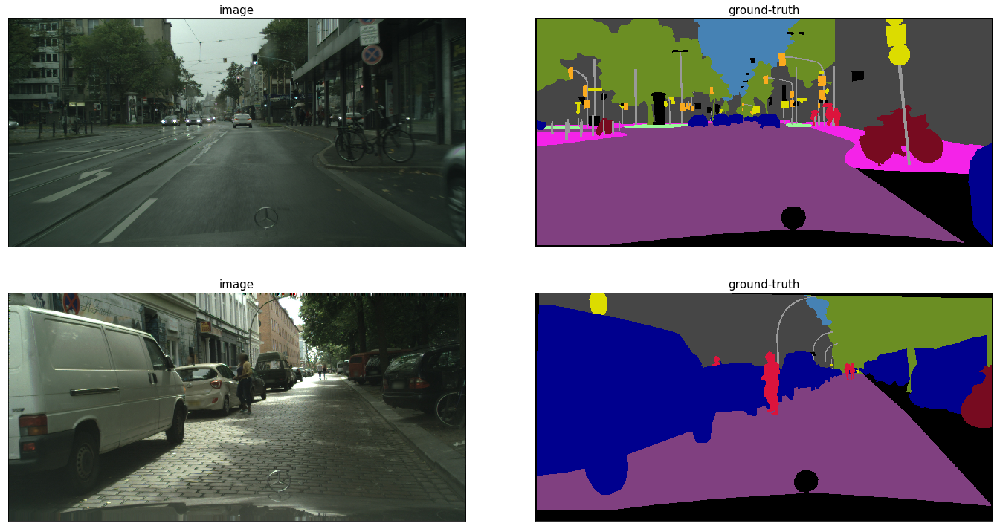

In [69]:
# !pip install scikit-image # <-- uncomment to install skimage with pip
import skimage.io as io
import matplotlib.pyplot as plt
from plot_utils import plot_image_grid

num_show = 2
np.random.seed(seed)
random_ids = np.random.choice(len(train_input_files), size=num_show)

train_input_files_samples = [train_input_files[i] for i in random_ids]
train_gt_files_samples = [train_gt_files[i] for i in random_ids]

images_samples = [io.imread(file) for file in train_input_files_samples]
gt_samples = [io.imread(file) for file in train_gt_files_samples]
gt_colors = [convert_labels_to_colors_numpy(mask) for mask in gt_samples]
figure = plot_image_grid([images_samples, gt_colors], ["image", "ground-truth"])
figure.show()

As we can see, the label maps are quite precise. In the next notebooks, the task of our networks will be to reproduce such results. Given these urban images, they will have to classify each pixel, returning for each their probability to belong to each class. Selecting the highest value for each pixel, we could then convert these predictions into such label maps.

**Note:** the elements left in black correspond to the miscellaneous we decided to ignore.

## Setting Up the Input Pipeline

We will now use the `tf.data` API to build an input pipeline, to serve the training/validation batches to our future models.

### Image Parsing and Augmentation

We first define some TensorFlow-based functions to parse the image and label files into proper tensors, then optionally to augment the data.

To simplify a bit the models later, we will change the ratio of the dataset images, making them square (the FCN-8s model we will use is based on VGG-16, built for $224 \times 224$ images[$^2$](#ref)). In order to scale the predictions back to the original shape in post-processing, we will save the original ratio/shape:

In [54]:
CITYSCAPES_IMG_RATIO = int(images[0].shape[1]) / int(images[0].shape[0])
print("Cityscape image shape = {} --> ratio = {} (to reshape squared images later)".format(
    images[0].shape, CITYSCAPES_IMG_RATIO))

Cityscape image shape = (1024, 2048, 3) --> ratio = 2.0 (to reshape squared images later)


The following function (based on the one already used in the previous notebook) parses the pairs of the filenames yielded by our data pipeline, into tensors:

In [65]:
def parse_function(filenames, resize_to=[226, 226], augment=True):
    """
    Parse files into input/label image pair.
    :param filenames:   Dict containing the file(s) (filenames['image'], filenames['label'])
    :param resize_to:   H x W Dimensions to resize the image and label to
    :param augment:     Flag to augment the pair
    :return:            Input tensor, Label tensor
    """

    img_filename, gt_filename = filenames['image'], filenames.get('label', None)

    # Reading the file and returning its content as bytes:
    image_string = tf.io.read_file(img_filename)
    # Decoding into an image:
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)

    # Converting image to float:
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)

    # Resizing:
    image = tf.image.resize(image, resize_to)

    if gt_filename is not None:
        # Same for GT image:
        gt_string = tf.io.read_file(gt_filename)
        gt_decoded = tf.io.decode_png(gt_string, channels=1)
        gt = tf.cast(gt_decoded, dtype=tf.int32)
        gt = tf.image.resize(gt, resize_to, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        # Opt. augmenting the image:
        if augment:
            image, gt = _augmentation_fn(image, gt)
        return image, gt
    else:
        if augment:
            image = _augmentation_fn(image)
        return image

Optionally, the pipeline may also augment the data, applying various random transformations (random color/brightness changes, random horizontal flip, random cropping/scaling, etc.). However, unlike the previous pipelines, we have to be careful to apply some transformations both to the input image and to the target label map. Indeed, if we flip or crop the image, the same should be done to the label map, so the two stay aligned. 

In [66]:
def _augmentation_fn(image, gt_image=None):
    """
    Apply random transformations to augment the training images.
    :param images:      Images
    :return:            Augmented Images
    """

    original_shape = tf.shape(image)[-3:-1]
    num_image_channels = tf.shape(image)[-1]

    # If we decide to randomly flip or resize/crop the image, the same should be applied to
    # the label one so they still match. Therefore, to simplify the procedure, we stack the
    # two images together along the channel axis, before these random operations:
    if gt_image is None:
        stacked_images = image
        num_stacked_channels = num_image_channels
    else:
        stacked_images = tf.concat([image, tf.cast(gt_image, dtype=image.dtype)], axis=-1)
        num_stacked_channels = tf.shape(stacked_images)[-1]

    # Randomly applied horizontal flip:
    stacked_images = tf.image.random_flip_left_right(stacked_images)

    # Random cropping:
    random_scale_factor = tf.random.uniform([], minval=.8, maxval=1., dtype=tf.float32)
    crop_shape = tf.cast(tf.cast(original_shape, tf.float32) * random_scale_factor, tf.int32)
    if len(stacked_images.shape) == 3:  # single image:
        crop_shape = tf.concat([crop_shape, [num_stacked_channels]], axis=0)
    else:  # batched images:
        batch_size = tf.shape(stacked_images)[0]
        crop_shape = tf.concat([[batch_size], crop_shape, [num_stacked_channels]], axis=0)
    stacked_images = tf.image.random_crop(stacked_images, crop_shape)

    # The remaining transformations should be applied either differently to the input and GT images
    # (nearest-neighbor resizing for the label image VS interpolated resizing for the image),
    # or only to the input image, not the GT one (color changes, etc.). Therefore, we split them back:
    image = stacked_images[..., :num_image_channels]

    # Resizing back to expected dimensions:
    image = tf.image.resize(image, original_shape)

    # Random B/S changes:
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.75)
    image = tf.clip_by_value(image, 0.0, 1.0)  # keeping pixel values in check

    if gt_image is not None:
        gt_image = tf.cast(stacked_images[..., num_image_channels:], dtype=gt_image.dtype)
        gt_image = tf.image.resize(gt_image, original_shape, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return image, gt_image
    else:
        return image

**Note:** In Chapter 7, we will explain in more details some of the operations done above, in case it is not fully clear yet.

We can finally put everything together, and wrap them into an input function we could later simply call to instantiate the data pipeline:

In [82]:
import functools

def segmentation_input_fn(image_files, gt_files=None, resize_to=[256, 256],
                          shuffle=False, batch_size=32, num_epochs=None, augment=False,
                          seed=None):
    """
    Set up an input data pipeline for semantic segmentation applications.
    :param image_files:     List of input image files
    :param gt_files:        (opt.) List of corresponding label image files
    :param resize_to:       H x W Dimensions to resize the image and label to
    :param shuffle:         Flag to shuffle the dataset
    :param batch_size:      Batch size
    :param num_epochs:      Number of epochs the dataset would be iterated over
    :param augment:         Flag to augment the pairs
    :param seed:            (opt) Seed
    :return:                tf.data.Dataset
    """
    # Converting to TF dataset:
    image_files = tf.constant(image_files)
    data_dict = {'image': image_files}
    if gt_files is not None:
        gt_files = tf.constant(gt_files)
        data_dict['label'] = gt_files
    dataset = tf.data.Dataset.from_tensor_slices(data_dict)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=seed)
    dataset = dataset.prefetch(1)

    # Batching + adding parsing operation:
    parse_fn = functools.partial(parse_function, resize_to=resize_to, augment=augment)
    dataset = dataset.map(parse_fn, num_parallel_calls=4)
    dataset = dataset.batch(batch_size)

    dataset = dataset.repeat(num_epochs)
    return dataset


def cityscapes_input_fn(split='train', root_folder=CITYSCAPES_FOLDER, resize_to=[256, 256],
                        shuffle=False, batch_size=32, num_epochs=None, augment=False,
                        seed=None, blurred=False):
    """
    Set up an input data pipeline for semantic segmentation applications on Cityscapes dataset.
    :param split:           Split name ('train', 'val', 'test')
    :param root_folder:     Cityscapes root folder
    :param resize_to:       H x W Dimensions to resize the image and label to
    :param shuffle:         Flag to shuffle the dataset
    :param batch_size:      Batch size
    :param num_epochs:      Number of epochs the dataset would be iterated over
    :param augment:         Flag to augment the pairs
    :param seed:            (opt) Seed
    :param blurred:         Flag to use images with faces and immatriculation plates blurred
                            (for display)
    :return:                tf.data.Dataset
    """

    type = "leftImg8bit_blurred" if blurred else "leftImg8bit"
    input_files, gt_files = get_cityscapes_file_pairs(split=split, root_folder=root_folder, type=type)
    return segmentation_input_fn(input_files, gt_files,
                                 resize_to, shuffle, batch_size, num_epochs, augment, seed)

Example how these methods can be later called:

In [83]:
batch_size = 16
num_epochs = 50
image_size = [512, 512]

train_dataset = segmentation_input_fn(
    train_input_files_samples, train_gt_files_samples, resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True)

val_dataset = segmentation_input_fn(
    val_input_files, val_gt_files, resize_to=image_size, batch_size=batch_size,
    shuffle=False, num_epochs=None, augment=False)

### Visualization Tools

As additional helpers for later, we define some methods to post-process results, e.g., for visualization:

In [84]:
# TF constant corresponding to our color list:
CITYSCAPES_COLORS_TF = tf.constant(CITYSCAPES_COLORS, dtype=tf.int32)

def change_ratio(image=None, pred=None, gt=None, ratio=CITYSCAPES_IMG_RATIO):
    """
    Resze the images to the corresponding ratio.
    :param image:   (opt) Input image
    :param pred:    (opt) Predicted label image
    :param gt:      (opt) Target image
    :param ratio:   Ratio
    :return:        3 resized images
    """
    valid_input = image if image is not None else pred if pred is not None else gt
    current_size = tf.shape(valid_input)[-3:-1]
    width_with_ratio = tf.cast(tf.cast(current_size[1], tf.float32) * ratio, tf.int32)
    size_with_ratio = tf.stack([current_size[0], width_with_ratio], axis=0)
    if image is not None:
        image = tf.image.resize(image, size_with_ratio)
    if pred is not None:
        pred = tf.image.resize(pred, size_with_ratio, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    if gt is not None:
        gt = tf.image.resize(gt, size_with_ratio, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, pred, gt


def convert_label_to_colors(label, one_hot=True, num_classes=len(CITYSCAPES_LABELS),
                            color_tensor=CITYSCAPES_COLORS_TF):
    """
    Convert label images into color ones for display (for Tensors).
    :param label:           Label image (Tensor)
    :param one_hot:         Flag if the label image hasn't been one-hot yet and therefore should
    :param num_classes:     Number of classes (for one-hotting)
    :param color_tensor:    Tensor mapping labels to colors
    :return:                Color map
    """

    label_shape = tf.shape(label)
    color_channels = tf.shape(color_tensor)[-1]

    if one_hot:
        label = tf.one_hot(label, num_classes)
    else:
        label_shape = label_shape[:-1]

    label = tf.reshape(tf.cast(label, tf.int32), (-1, num_classes))
    colors = tf.matmul(label, color_tensor)

    return tf.reshape(colors, tf.concat([label_shape, [color_channels]], axis=0))


def postprocess_to_show(image=None, pred=None, gt=None, one_hot=True, ratio=CITYSCAPES_IMG_RATIO):
    """
    Post-process the training results of a segmentation model (as Tensors), for display.
    :param image:       (opt.) Input image tensor
    :param pred:        (opt.) Predicted label map tensor
    :param gt:          (opt.) Target label map tensor
    :param one_hot:     Flag if the predicted label image hasn't been one-hot yet and therefore should
    :param ratio:       Original image ratio
    :return:            Processed image tensor(s)
    """
    out = []
    image_show, pred_show, gt_show = change_ratio(image, pred, gt,
                                                  ratio)
    if image is not None:
        out.append(image_show)

    if pred is not None:
        if one_hot:
            pred_show = tf.squeeze(pred_show, -1)  # removing unnecessary channel dimension
        pred_show = convert_label_to_colors(pred_show, one_hot=one_hot)
        out.append(pred_show)

    if gt is not None:
        gt_show = tf.squeeze(gt_show, -1)  # removing unnecessary channel dimension
        gt_show = convert_label_to_colors(gt_show)
        out.append(gt_show)

    return out if len(out) > 1 else out[0]

Let us directly apply these methods to the visualization of some augmented training images:

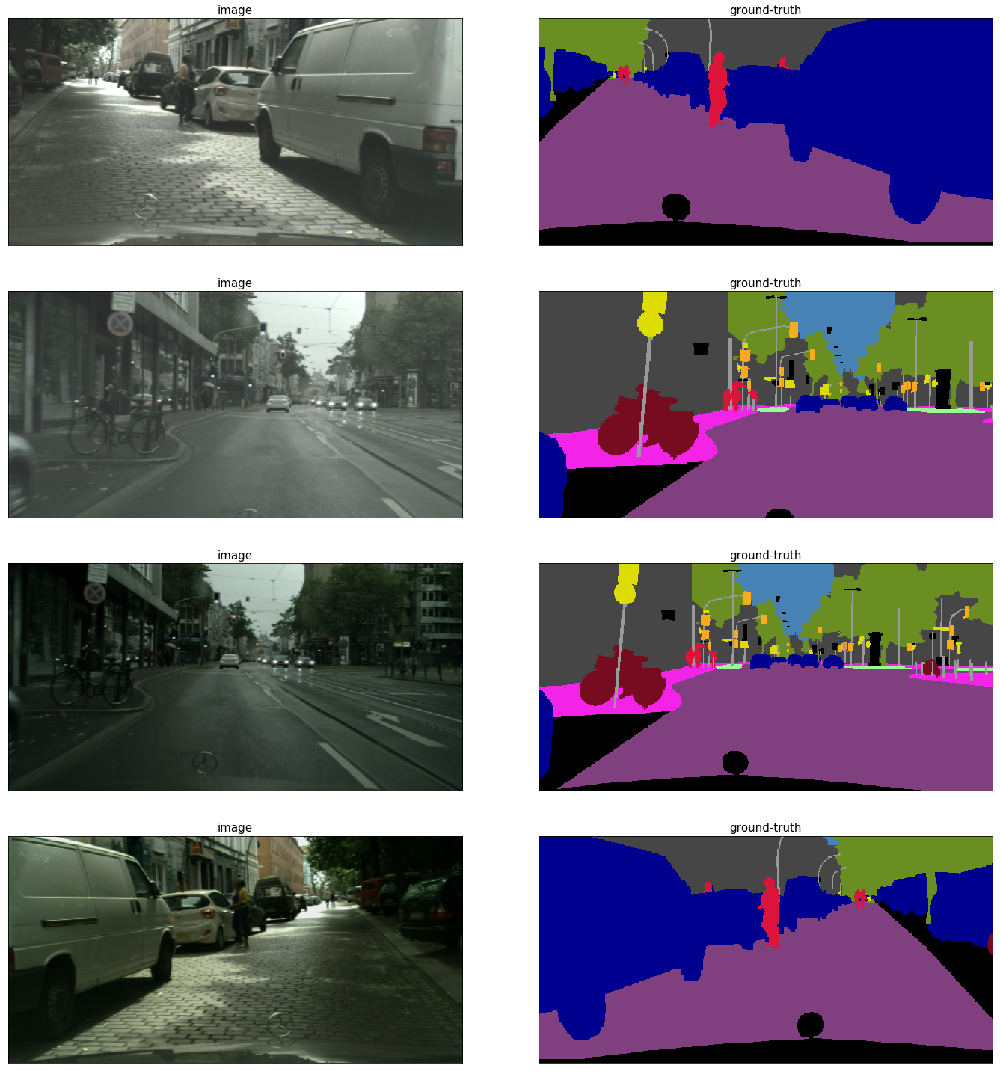

In [85]:
train_dataset_iter = train_dataset.__iter__()
train_images1, train_labels1 =  next(train_dataset_iter)
train_images2, train_labels2 =  next(train_dataset_iter)

train_images = np.concatenate((train_images1[:num_show], train_images2[:num_show]), axis=0)
train_labels = np.concatenate((train_labels1[:num_show], train_labels2[:num_show]), axis=0)

image_show, gt_show = postprocess_to_show(train_images, train_labels)
    
figure = plot_image_grid([image_show, gt_show], 
                         ["image", "ground-truth"])
figure.show()

## Conclusion

Preparing the input pipelines for new applications is often a time-consuming task. It is important for instance to have a look at some samples and make sure the parsing/augmentation methods are working as expected, before launching any training.

We are now ready to tackle a real-life application of semantic segmentation in the next notebooks.

<a id="ref"></a>
#### References

1. Cordts, M., Omran, M., Ramos, S., Rehfeld, T., Enzweiler, M., Benenson, R., Franke, U., Roth, S., Schiele, B., 2016. The Cityscapes Dataset for Semantic Urban Scene Understanding. In: 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Presented at the 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, Las Vegas, NV, USA, pp. 3213–3223.
2. Shelhamer, E., Long, J., Darrell, T., 2017. Fully Convolutional Networks for Semantic Segmentation. IEEE Transactions on Pattern Analysis and Machine Intelligence 39, 640–651.